In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model
from matplotlib import gridspec

# adaptive-wavelets modules
from transform1d import DWT1d

# evaluation
from eval_biology import load_results, max_transformer
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

# load results

In [2]:
dirs = [
        "db5_saliency_warmstart_seed=1"
        ]
dics, results, models = load_results(dirs)

# prediction accuracy, compression, and computation time

In [4]:
r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
}

best_lam = []
best_wt = []

# params for feature transformer
sgn = "pos"
m = 6

index = 0
res = results[index]
mos = models[index]    

# load data
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)       


# cross validation
reg_score = []    

for i,wt in enumerate(list(dics[index]['wt'].values())):
    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = max_transformer(wt, 
                                               train_loader, 
                                               test_loader,
                                               sgn=sgn,
                                               m=m)


    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    reg_score.append(scores.mean())
reg_score = np.array(reg_score)    

# select best wavelet
idx1, idx2 = list(dics[index]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
idx = dics[index]['index'][(idx1, idx2)]
lamL1wave = dics[index]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[index]['lamL1attr'][(idx1, idx2)]
best_lam.append((lamL1wave, lamL1attr))
wt = dics[index]['wt'][(idx1, idx2)]
best_wt.append(wt)

# load pre-trained model
model = load_pretrained_model(p.model_path, device=device)   

p.batch_size = 3000
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
r['AWD (Ours)'].append(metrics.r2_score(y_test, preds))


wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)
(X, y), (X_test, y_test) = max_transformer(wt_o, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf_o = LinearRegression().fit(X, y)
preds = clf_o.predict(X_test)
r['Standard Wavelet (DB5)'].append(metrics.r2_score(y_test, preds))

print(r)

{'Standard Wavelet (DB5)': [0.19740176477695281], 'AWD (Ours)': [0.2625306384308951]}


In [5]:
from eval_biology import get_tensors, max_fun

In [6]:
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
print(metrics.r2_score(y_test, preds))

0.2625306384308951


# Plotting top coefs

In [7]:
wt = best_wt[0]
wt = wt.to('cpu')
J = wt.J

(Xs, y) = get_tensors(train_loader)
data_t = wt(Xs)
data_to = wt_o(Xs)

X = []
for j in range(J+1):
    d = data_t[j].detach().squeeze().numpy()
    X.append(max_fun(d, sgn=sgn, m=m))
X = np.hstack(X)
y = y.detach().squeeze().numpy()

idx = 149

In [8]:
def helper(wc: tuple, scale, nums):
    """ 
    Threshold attributions retaining those with top absolute attributions 
    """    
    wc = list(wc)
    batch_size = wc[0].shape[0]
    J = len(wc)
   
    for j in range(J):
        if j != scale: 
            wc[j] = torch.zeros_like(wc[j])
        else:
            b = wc[j].reshape(batch_size, -1)
    sort_indexes = torch.argsort(b, dim=1, descending=True)      
    
    m = torch.zeros_like(sort_indexes)
    for i in range(batch_size):
        for num in nums:
            m[i][sort_indexes[i,num]] = 1
        
    wc[scale] = torch.mul(m.reshape(wc[scale].shape), wc[scale])
    return wc

In [9]:
contr = X[idx] * clf.coef_
idx_pos = np.argwhere(contr > 0).squeeze()
idx_scale = []
idx_contr = []
for j in range(J+1):
    r = [i-6*j for i in idx_pos if 6*j <= i < 6*(j+1)]
    c = [contr[i] for i in idx_pos if 6*j <= i < 6*(j+1)]
    idx_scale.append(r)
    idx_contr.append(c)

In [67]:
idx_contr

[[0.49278677, 0.18012384, 0.00016773715],
 [0.13867685],
 [0.08258016, 0.00023208719, 0.00897958],
 [0.045183793, 0.08895969, 0.000116076764, 4.689269e-05],
 [0.06519712, 0.00014281218, 0.0035567433]]

In [69]:
idx_scale

[[0, 1, 5], [5], [2, 4, 5], [1, 2, 3, 4], [0, 1, 4]]

NameError: name 'labels' is not defined

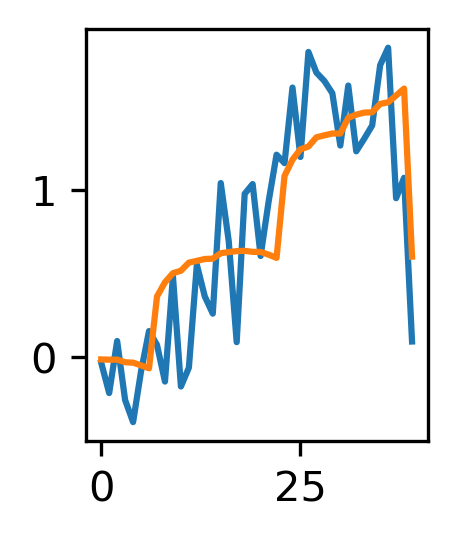

In [14]:

fig = plt.figure(dpi=300, figsize=(5,4))
x = Xs[idx,0].squeeze().detach().numpy()
x_rs = []
num_rows = 2
num_cols = 3

for i in range(6):
    # distance plot
    plt.subplot(num_rows, num_cols, i + 1)
    
    if i <= 4:
        dt = helper(data_t, i, idx_scale[i])
        x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
        plt.plot(x)
        plt.plot(x_r)
        x_rs.append(x_r)
        
    if i == 5:
        x_r = 0
        for a in x_rs:
            x_r += a
        plt.plot(x)
        plt.plot(x_r)
        
    plt.title(labels[i], fontsize=10)
    plt.axis('off')

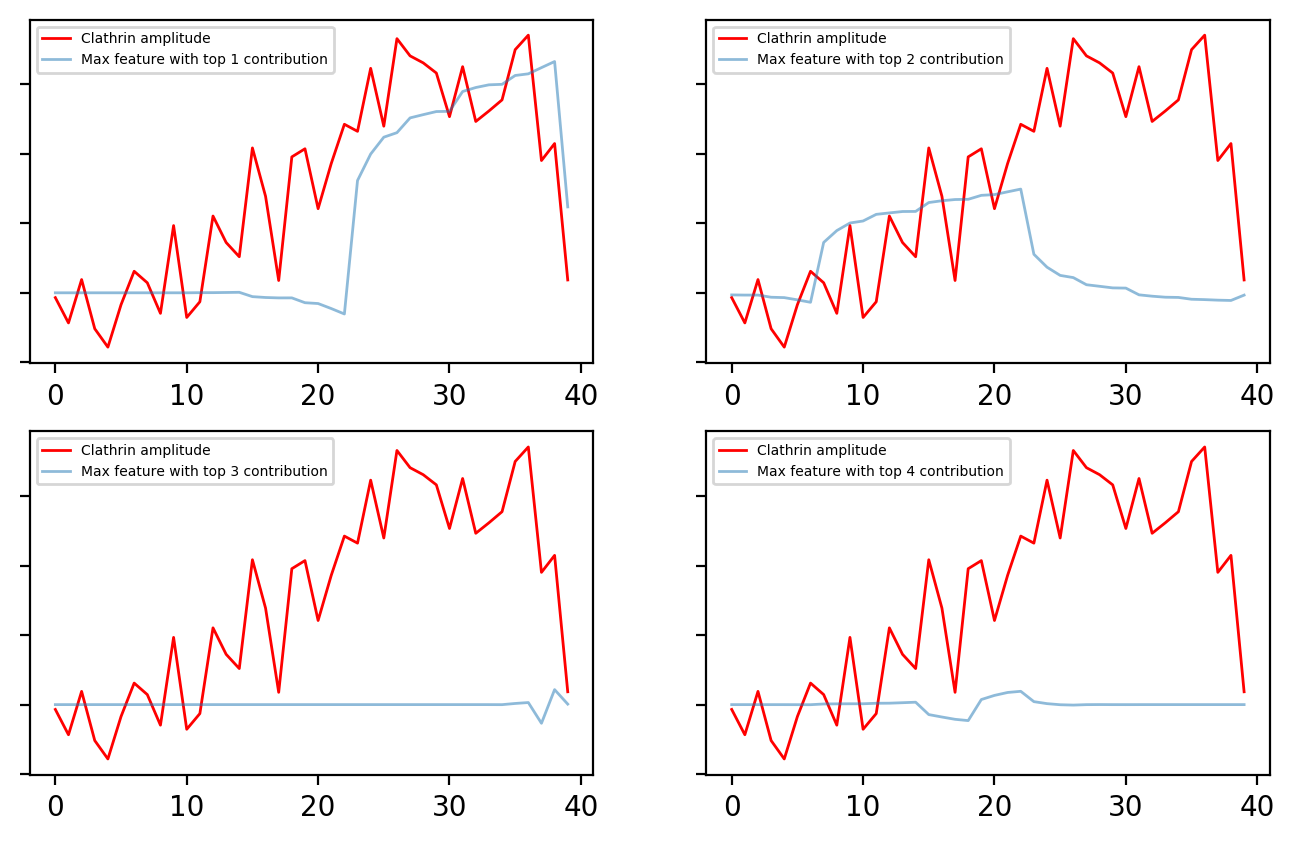

In [15]:
fig = plt.figure(figsize=(8,5), dpi=200)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'C0']

x = Xs[idx,0].squeeze().detach().numpy()

ax_00 = fig.add_subplot(spec[0, 0])
dt = helper(data_t, 0, [0])
x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
ax_00.plot(x, lw=1, color=colors[0], label="Clathrin amplitude")
ax_00.plot(x_r, lw=1, color=colors[1], alpha=0.5, label="Max feature with top 1 contribution")
ax_00.set_yticklabels([])
ax_00.legend(fontsize=5, loc='upper left', fancybox=True)    


ax_01 = fig.add_subplot(spec[0, 1])
dt = helper(data_t, 0, [1])
x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
ax_01.plot(x, lw=1, color=colors[0], label="Clathrin amplitude")
ax_01.plot(x_r, lw=1, color=colors[1], alpha=0.5, label="Max feature with top 2 contribution")
ax_01.set_yticklabels([])
ax_01.legend(fontsize=5, loc='upper left', fancybox=True)  


ax_10 = fig.add_subplot(spec[1, 0])
dt = helper(data_t, 1, [5])
x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
ax_10.plot(x, lw=1, color=colors[0], label="Clathrin amplitude")
ax_10.plot(x_r, lw=1, color=colors[1], alpha=0.5, label="Max feature with top 3 contribution")
ax_10.set_yticklabels([])
ax_10.legend(fontsize=5, loc='upper left', fancybox=True)  


ax_11 = fig.add_subplot(spec[1, 1])
dt = helper(data_t, 3, [2])
x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
ax_11.plot(x, lw=1, color=colors[0], label="Clathrin amplitude")
ax_11.plot(x_r, lw=1, color=colors[1], alpha=0.5, label="Max feature with top 4 contribution")
ax_11.set_yticklabels([])
ax_11.legend(fontsize=5, loc='upper left', fancybox=True)  

fig.savefig(
    "figures/bio_viz_important_features.pdf", bbox_inches="tight", pad_inches=0.0
)

# remade fig

In [68]:
idx_contr

[[0.49278677, 0.18012384, 0.00016773715],
 [0.13867685],
 [0.08258016, 0.00023208719, 0.00897958],
 [0.045183793, 0.08895969, 0.000116076764, 4.689269e-05],
 [0.06519712, 0.00014281218, 0.0035567433]]

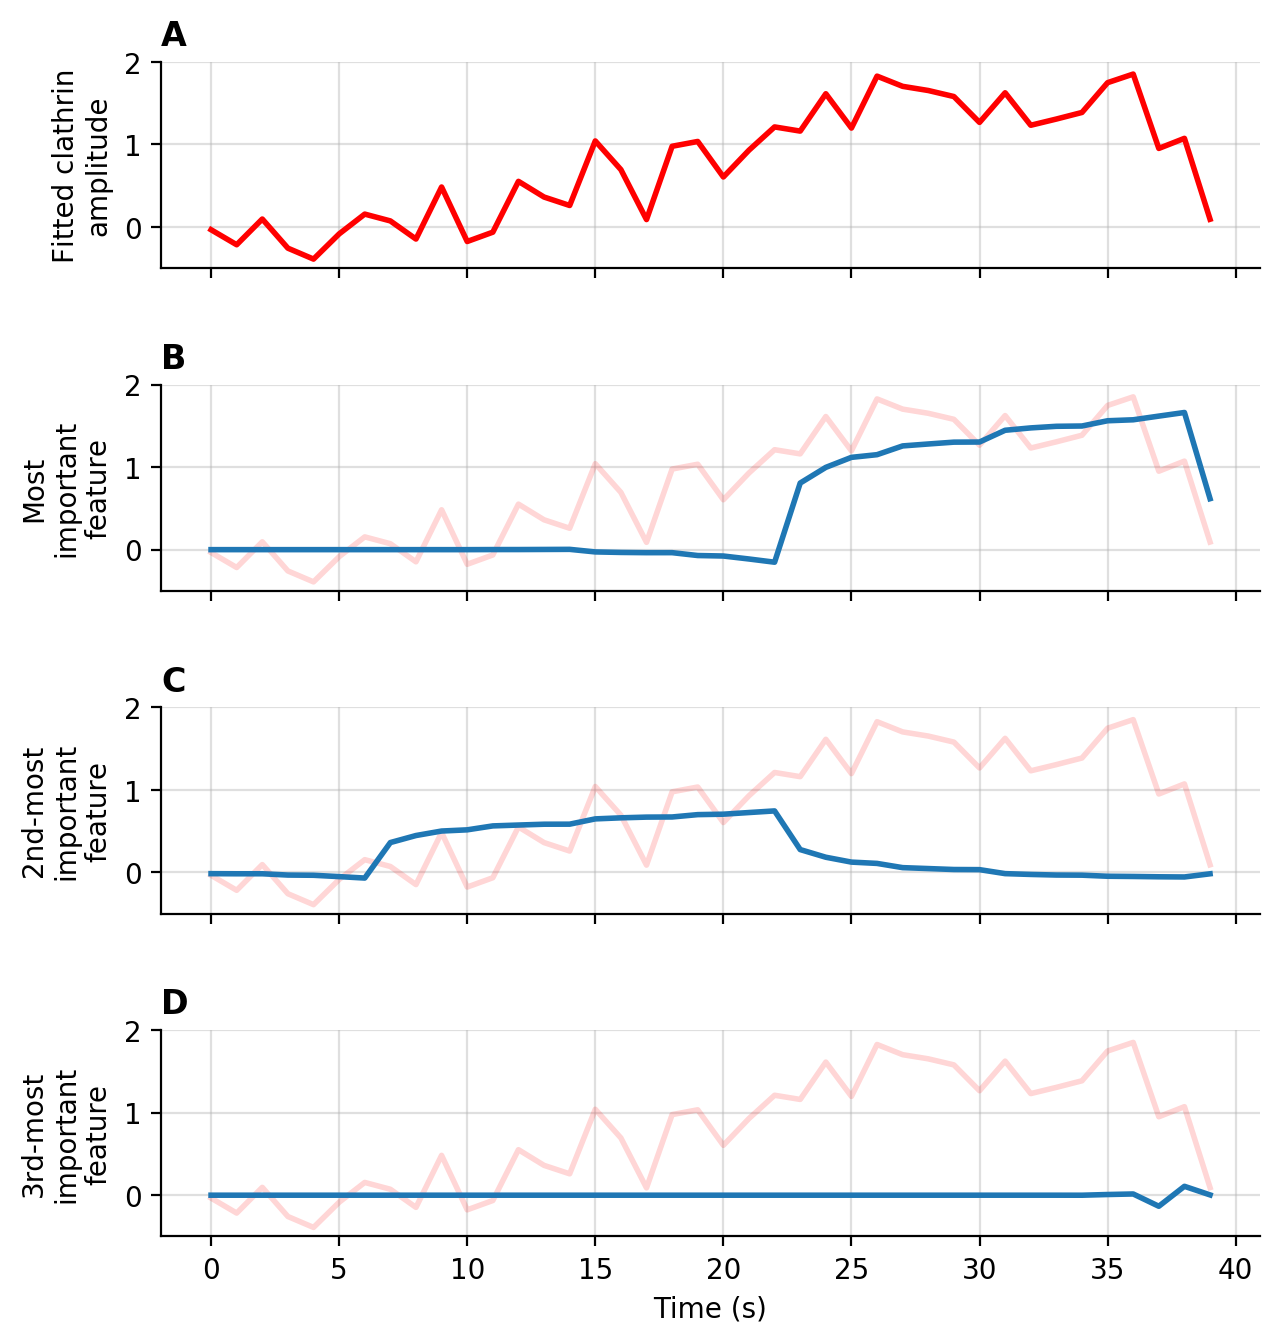

In [72]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize=(6.5, 8), dpi=200)


R, C = 5, 1
plt.subplot(R, C, 1)
x = Xs[idx,0].squeeze().detach().numpy()
ax = plt.plot(x, lw=2, color=colors[0], label="Clathrin amplitude")
plt.title('A', fontweight='bold', loc='left')
plt.ylim(-0.5, 2)
plt.grid(alpha=0.4)
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylabel('Fitted clathrin\namplitude')


N = 3
prefixes = ['Most', '2nd-most', '3rd-most']
lets = 'BCD'
for i, (l, n) in enumerate([(0, 0), (0, 1), (1, 5), (3, 2)][:N]):
    plt.subplot(R, C, 2 + i)
    plt.title(lets[i], fontweight='bold', loc='left')
    dt = helper(data_t, l, [n])
    x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()   
    plt.plot(x, lw=2, color=colors[0], label="Clathrin amplitude", alpha=0.16)
    plt.plot(x_r, lw=2)
    plt.ylim(-0.5, 2)
    plt.grid(alpha=0.4)
    if i < N - 1:
        plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel(prefixes[i] + '\nimportant\nfeature')
plt.xlabel('Time (s)')

plt.tight_layout()
fig.savefig(
    "figures/bio_viz_important_features_merged.pdf", bbox_inches="tight", pad_inches=0.3
)